### In this notebook we will see, how bottleneck Influences on simple ResNet.
ResNet: 
* [paper](https://arxiv.org/abs/1512.03385)
* [inplementation](https://github.com/analysiscenter/dataset/blob/master/dataset/models/tf/resnet.py)

### For that we train two networks presented below.
__First network__ a simple ResNet that includes five blocks:

feature of this network is we use only convolution with kernel 3x3, and skipconnetions without convolutions.

_total weights:_ __617472__

__Second model__ - Resnet with bottlenecks blocks:

In this case we use the convolutions 1×1 layers are responsible for reducing and then increasing (restoring)
dimensions(by change number of filters). Skip-Connections with 1x1 convolution.

_total weights:_ __211712__

In [1]:
import sys

import numpy as np
import seaborn as sns
import tensorflow as tf
from pandas import ewma
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
from tqdm import tqdm_notebook as tqn

sys.path.append('../..')
sys.path.append('..')
import utils
from dataset import B,V,F
from dataset.dataset.opensets import MNIST
from dataset.dataset.models.tf import ResNet

As always create MNIST batch class, configs for models and placeholders.

In [2]:
dset = MNIST()

ExtractingExtractingExtracting   /tmp/train-images-idx3-ubyte.gz/tmp/t10k-images-idx3-ubyte.gz/tmp/train-labels-idx1-ubyte.gz


Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [3]:
placeholders_config = {
                       'images': {'shape': (28, 28, 1)},
                
                       'labels': {'classes': (10),
                                  'transform': 'ohe',
                                  'dtype': 'int32',
                                  'name': 'targets'}
                       }

In [4]:
ResNet_config = {'inputs': placeholders_config,
                 'input_block/inputs': 'images',
                 'body/num_blocks': [2, 2],
                 'body/filters': [32, 64],
                 'loss': 'softmax_cross_entropy',
                 'optimizer': 'Adam',
            } 
Bottlenet_config = {**ResNet_config,
                          'body/block/bottleneck': 1}

In [5]:
placehold_dict = {'images': B('images'),
                  'labels': B('labels')}

Based on our config, create pipelines and train it. Interest thing, we not wirte ResNet by our hand, we took it from dataset models and just create config file with needed configuration. How it works you can see [here](https://analysiscenter.github.io/dataset/api/dataset.models.html).

In [6]:
res_tr_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet,
                      'resnet',
                      config=ResNet_config)
           .train_model('resnet',
                        feed_dict=placehold_dict))
res_test_ppl = (dset.test
           .p
           .init_variable('resloss', init_on_each_run=list)
           .import_model('resnet', res_tr_ppl)
           .predict_model('resnet',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('resloss'), mode='a'))

In [7]:
bott_tr_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet,
                      'bottle',
                      config=Bottlenet_config)
           .train_model('bottle',
                        feed_dict=placehold_dict))
bott_test_ppl = (dset.test
           .p
           .init_variable('bottloss', init_on_each_run=list)
           .import_model('bottle', bott_tr_ppl)
           .predict_model('bottle',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('bottloss'), mode='a'))

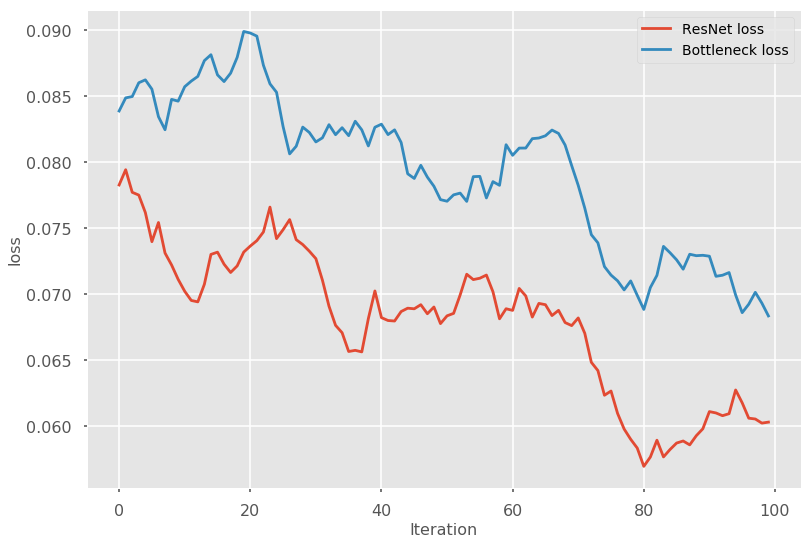

In [8]:
for i in tqn(range(500)):
    res_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    res_test_ppl.next_batch(400, n_epochs=None, shuffle=True)
    bott_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    bott_test_ppl.next_batch(400, n_epochs=None, shuffle=True)
    if i%10==0 and i != 0:
        clear_output(True)
        ResNet_loss = res_test_ppl.get_variable('resloss')[-100:]
        Bottle_loss = bott_test_ppl.get_variable('bottloss')[-100:]
        utils.draw(ResNet_loss, 'ResNet', Bottle_loss, 'Bottleneck')
        plt.show()

After training we can compare loss-values both models.

../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


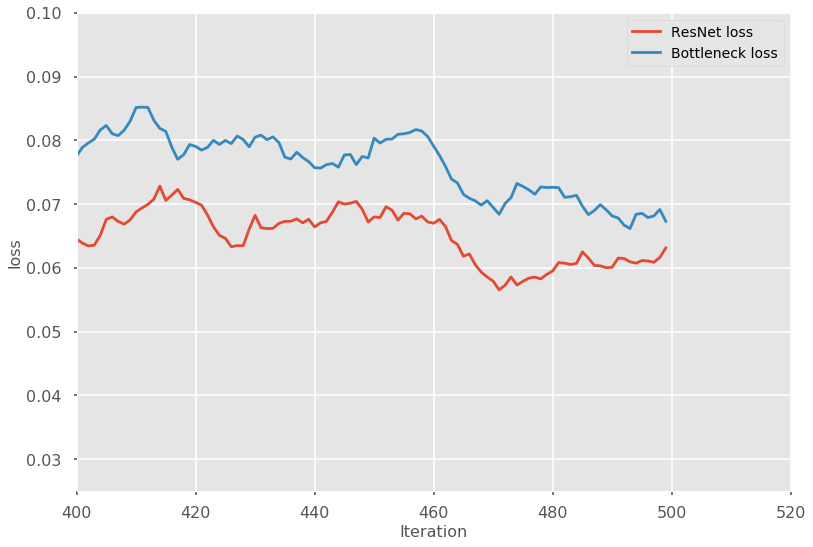

In [9]:
ResNet_loss = res_test_ppl.get_variable('resloss')
Bottle_loss = bott_test_ppl.get_variable('bottloss')
utils.draw(ResNet_loss, 'ResNet', Bottle_loss, 'Bottleneck', bound=[400, 520, 0.025, 0.1])

Network with bottleneck architectures has almost half the size of parameters, but training not worse than network with simple model. And bottleneck model train faster, than simple model.

Сonsider the impact of the bottleneck blocks on weights distribution

In [10]:
def get_weights(graph, session):
    
    weights, biases = [], []
    variables = graph.get_collection('trainable_variables')
    variables = [var for var in variables if 'batch_normalization' not in var.name][2:]
    names = np.array([layer.name.split('/')[5] if 'shortcut' not in layer.name else 'shortcut'\
                      for layer in variables[:-2:2]])
    
    weights_variables = [var for var in variables[:-2] if 'bias:0' not in var.name]
    biases_variables = [var for var in variables[:-2] if 'kernel:0' not in var.name]
    weights.append(session.run(weights_variables))
    biases.append(session.run(biases_variables))
    
    return names, np.array(weights[0]), np.array(biases[0])

Loading graph out of model and get all weights

In [11]:
bottle_sess = bott_tr_ppl.get_model_by_name("bottle").session
bottle_graph = bottle_sess.graph
bottle_names, bottle_weights, bottle_bias = get_weights(bottle_graph, bottle_sess)

In [12]:
res_sess = res_tr_ppl.get_model_by_name("resnet").session
res_graph = res_sess.graph
res_names, res_weights, res_bias = get_weights(res_graph, res_sess)

Let's count the numbers of parameters on each layer.

In [13]:
bottle_params = np.array([np.array(i.shape).prod() for i in bottle_weights] + [0, 0, 0])
res_params = np.array([np.array(i.shape).prod() for i in res_weights])

Draw the distribution of weights of convolutional layers from Bottleneck ResNet model. All function you can see in [utils](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/utils.py).

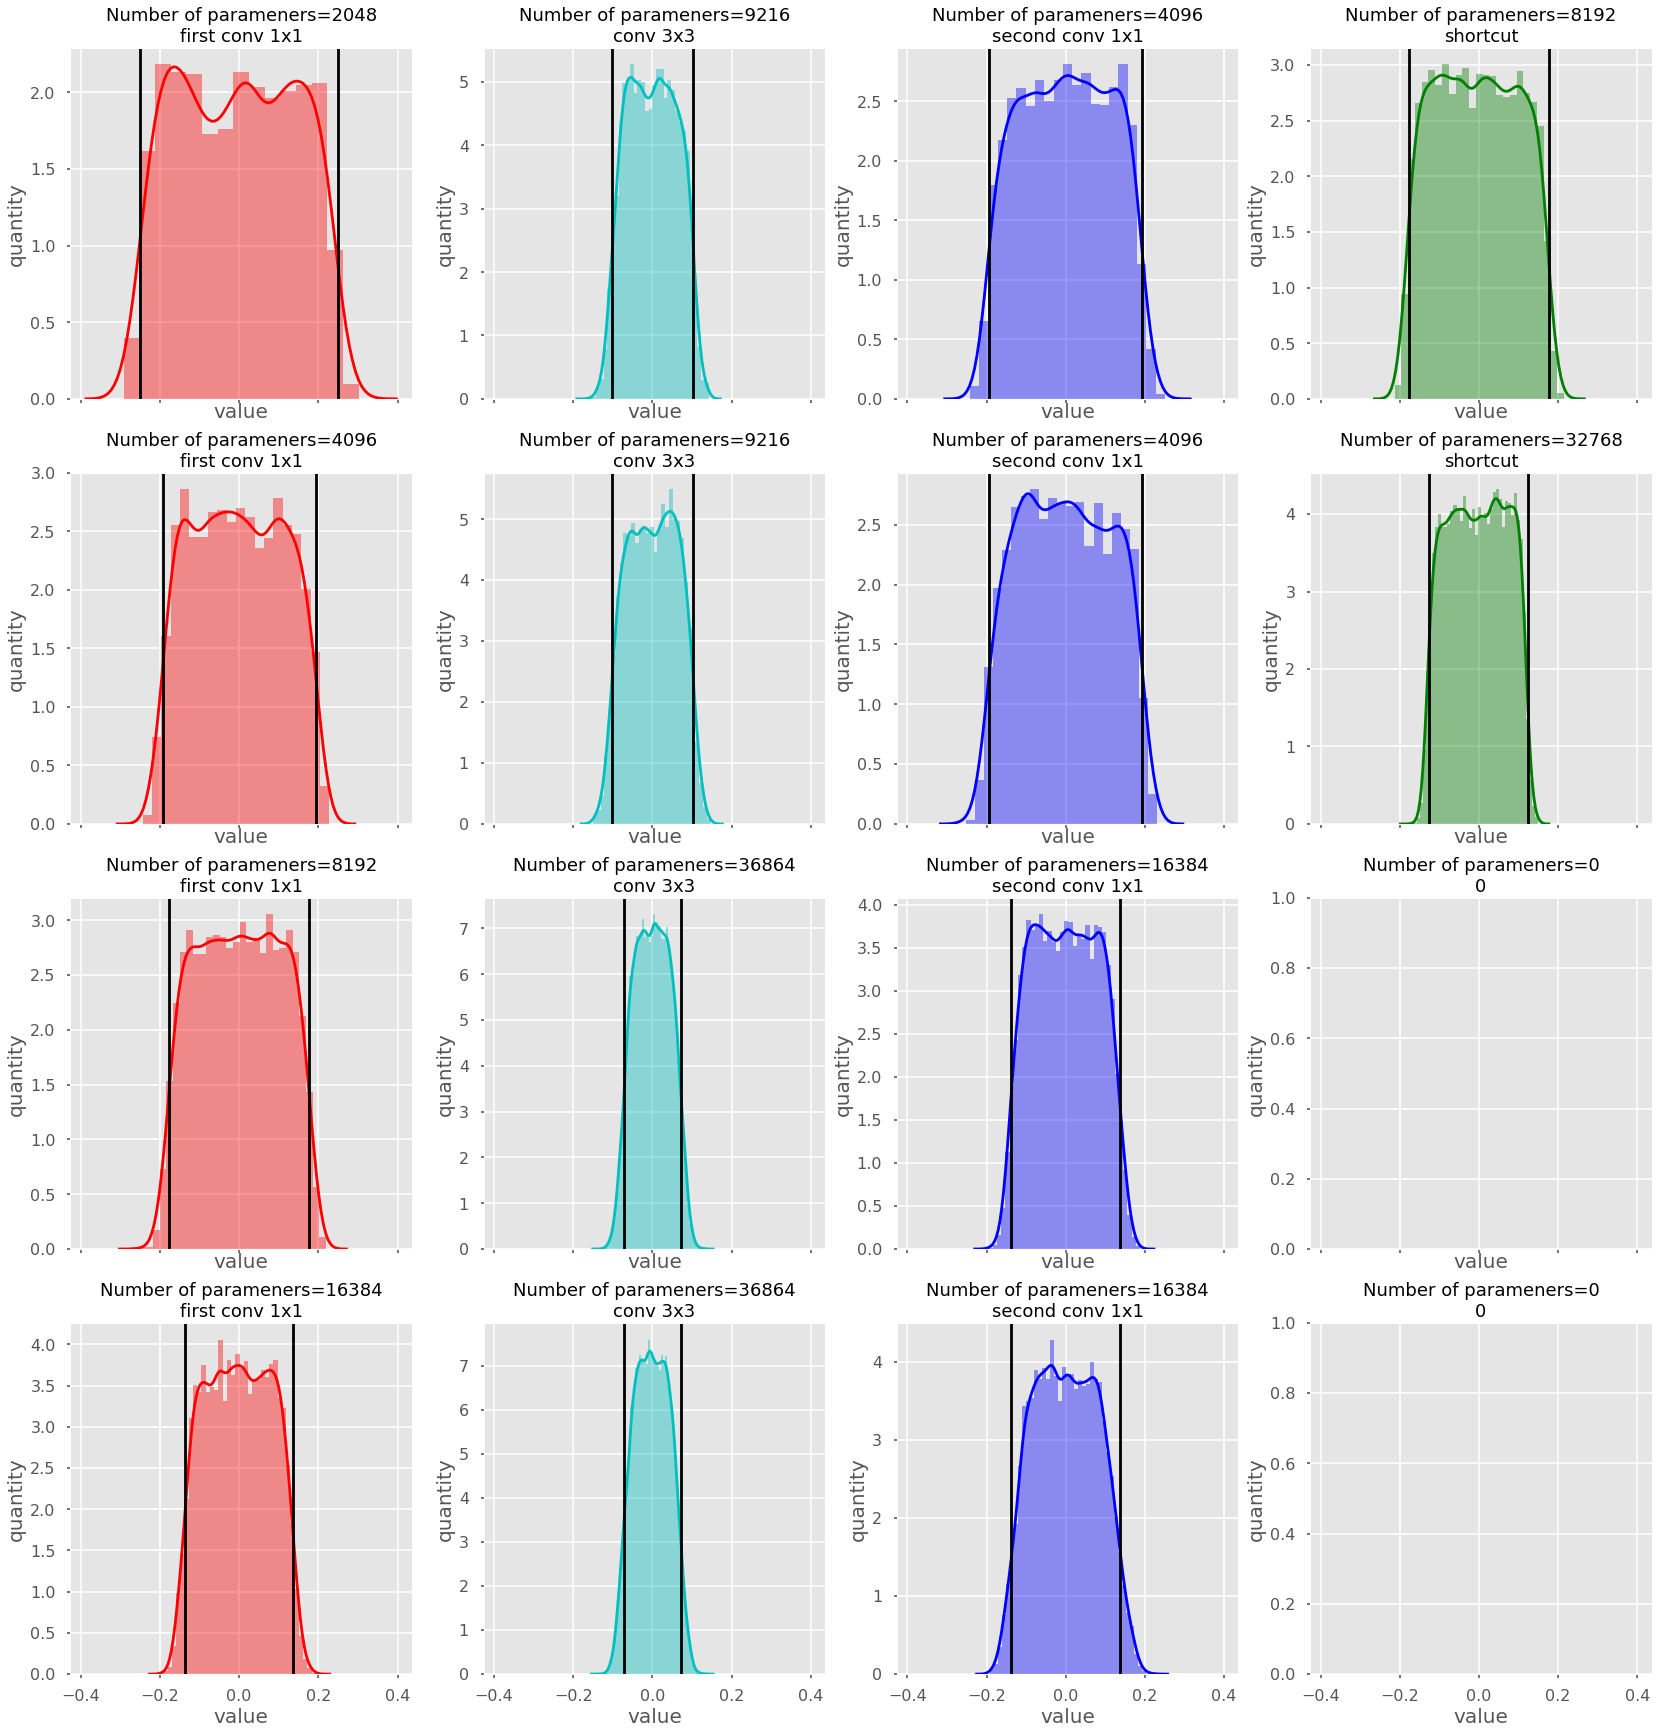

In [14]:
utils.plot_weights(bottle_names, bottle_weights, bottle_params, ['r', 'c', 'b', 'g'], [4, 4])

It's not difficult to notice, that distribution of 1x1 convolutions have a large variance, than convolution 3x3. Therefore, they exert a stronger influence on output.

 __Black lines show the initial distribution of weights__

______

It's time to draw distribution of ResNet model __without__ bottleneck.

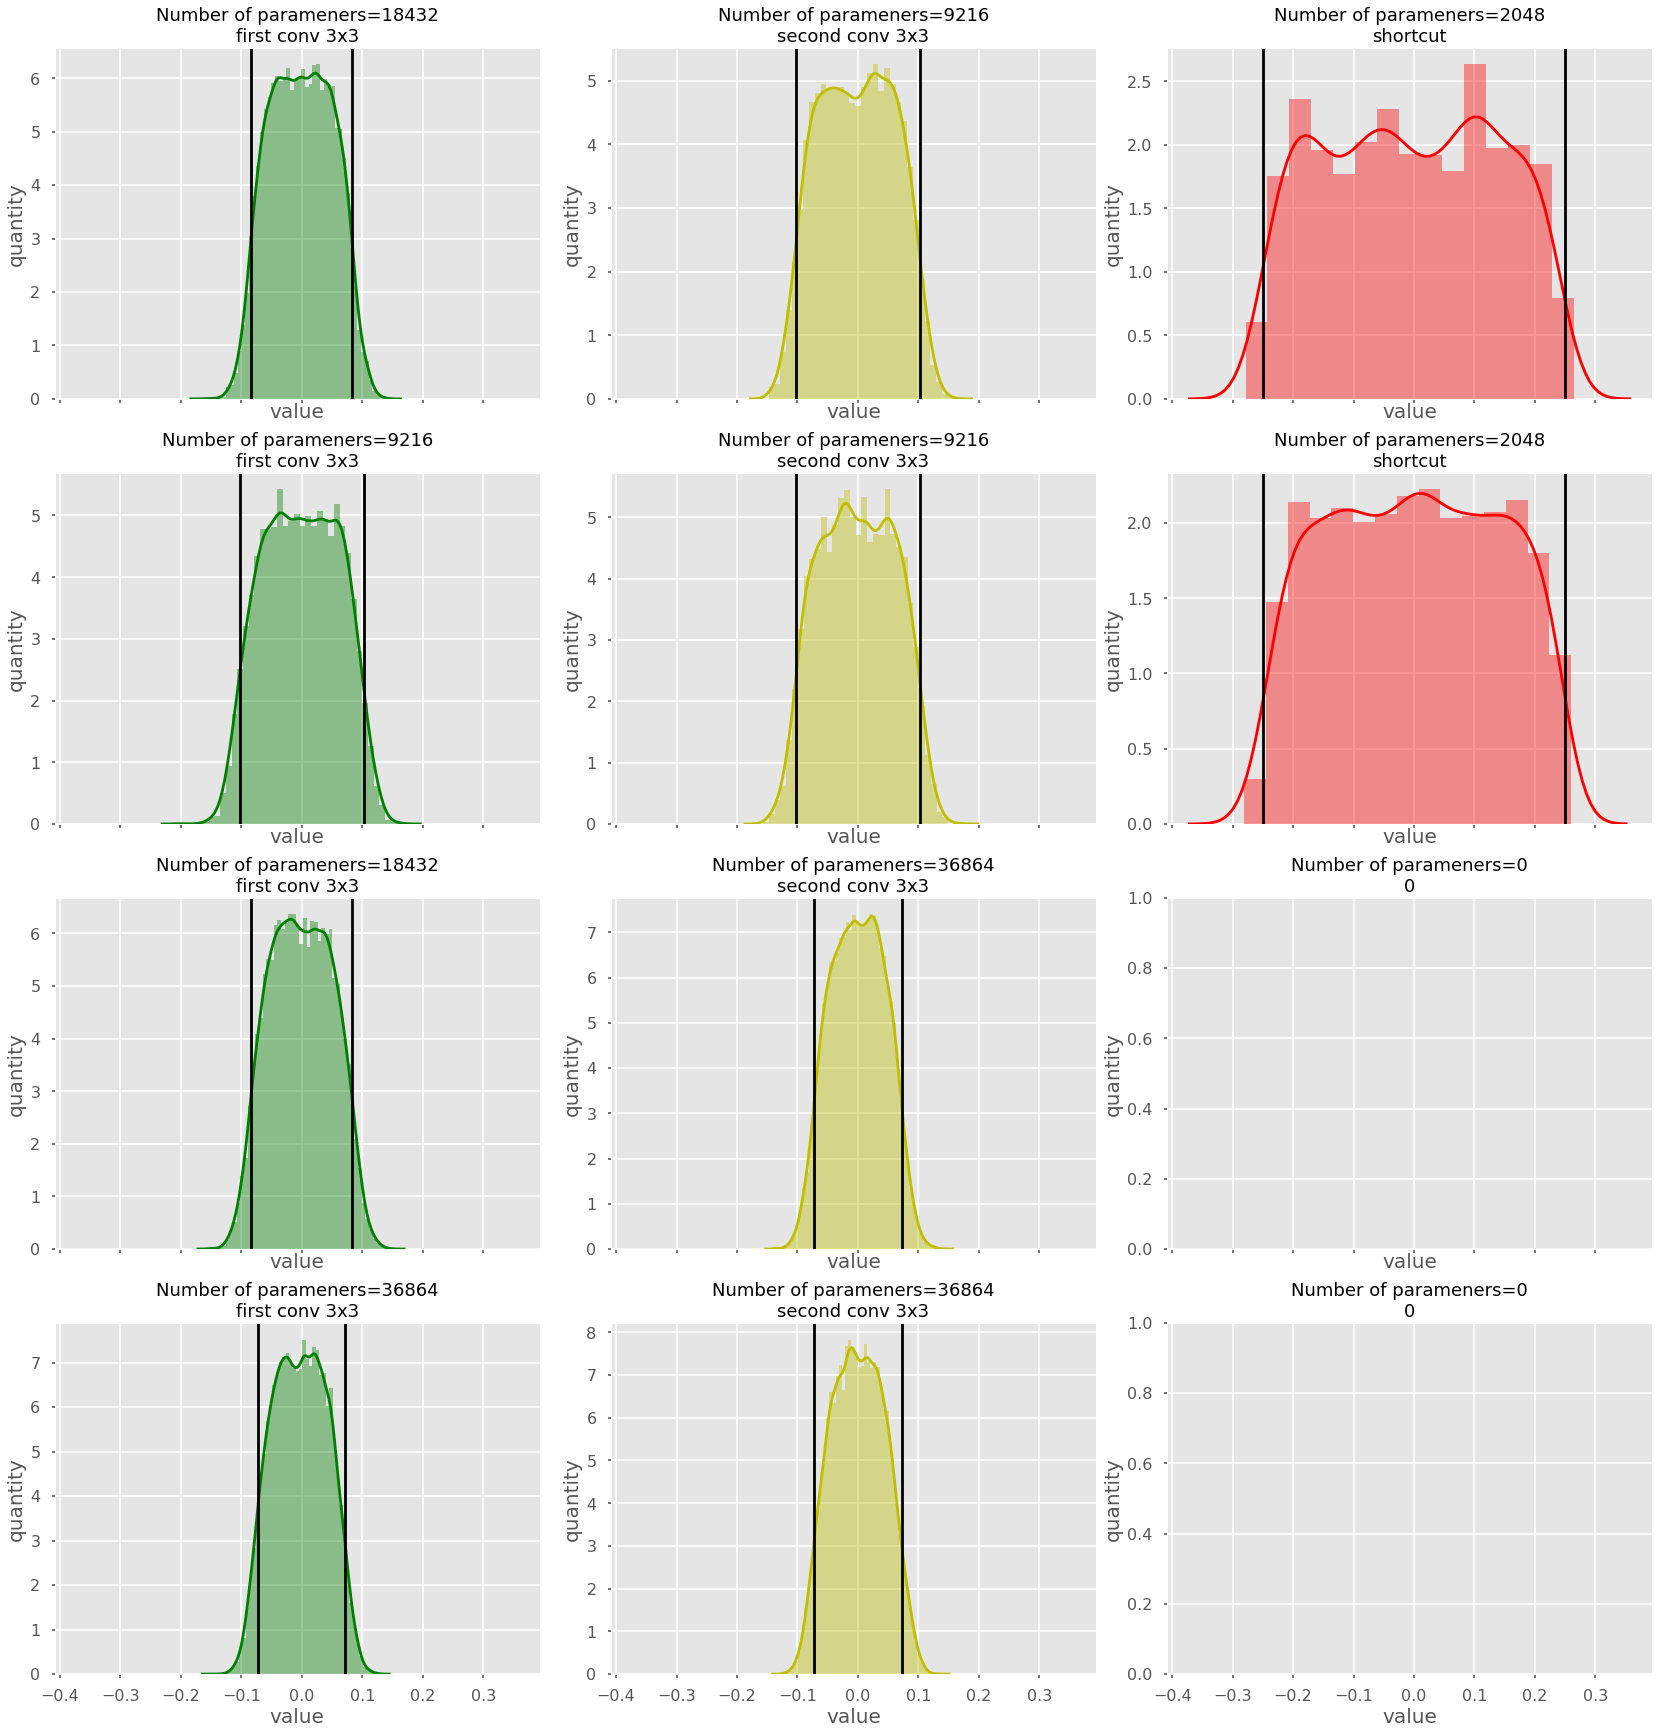

In [15]:
utils.plot_weights(res_names, res_weights, res_params, ['g', 'y', 'r'], [4, 3], bottleneck=False)

looking at the graphs you can see, that distribution of first convolution layers almost did not change, it happend because skipconnection allows change the weights of second convolution layer more than first. Hence, greater in comparison with the first distribution of second layer.

____

Now, let's compare the distribution of second layer of simple ResNet architecture and ResNet with bottlenecks blocks.

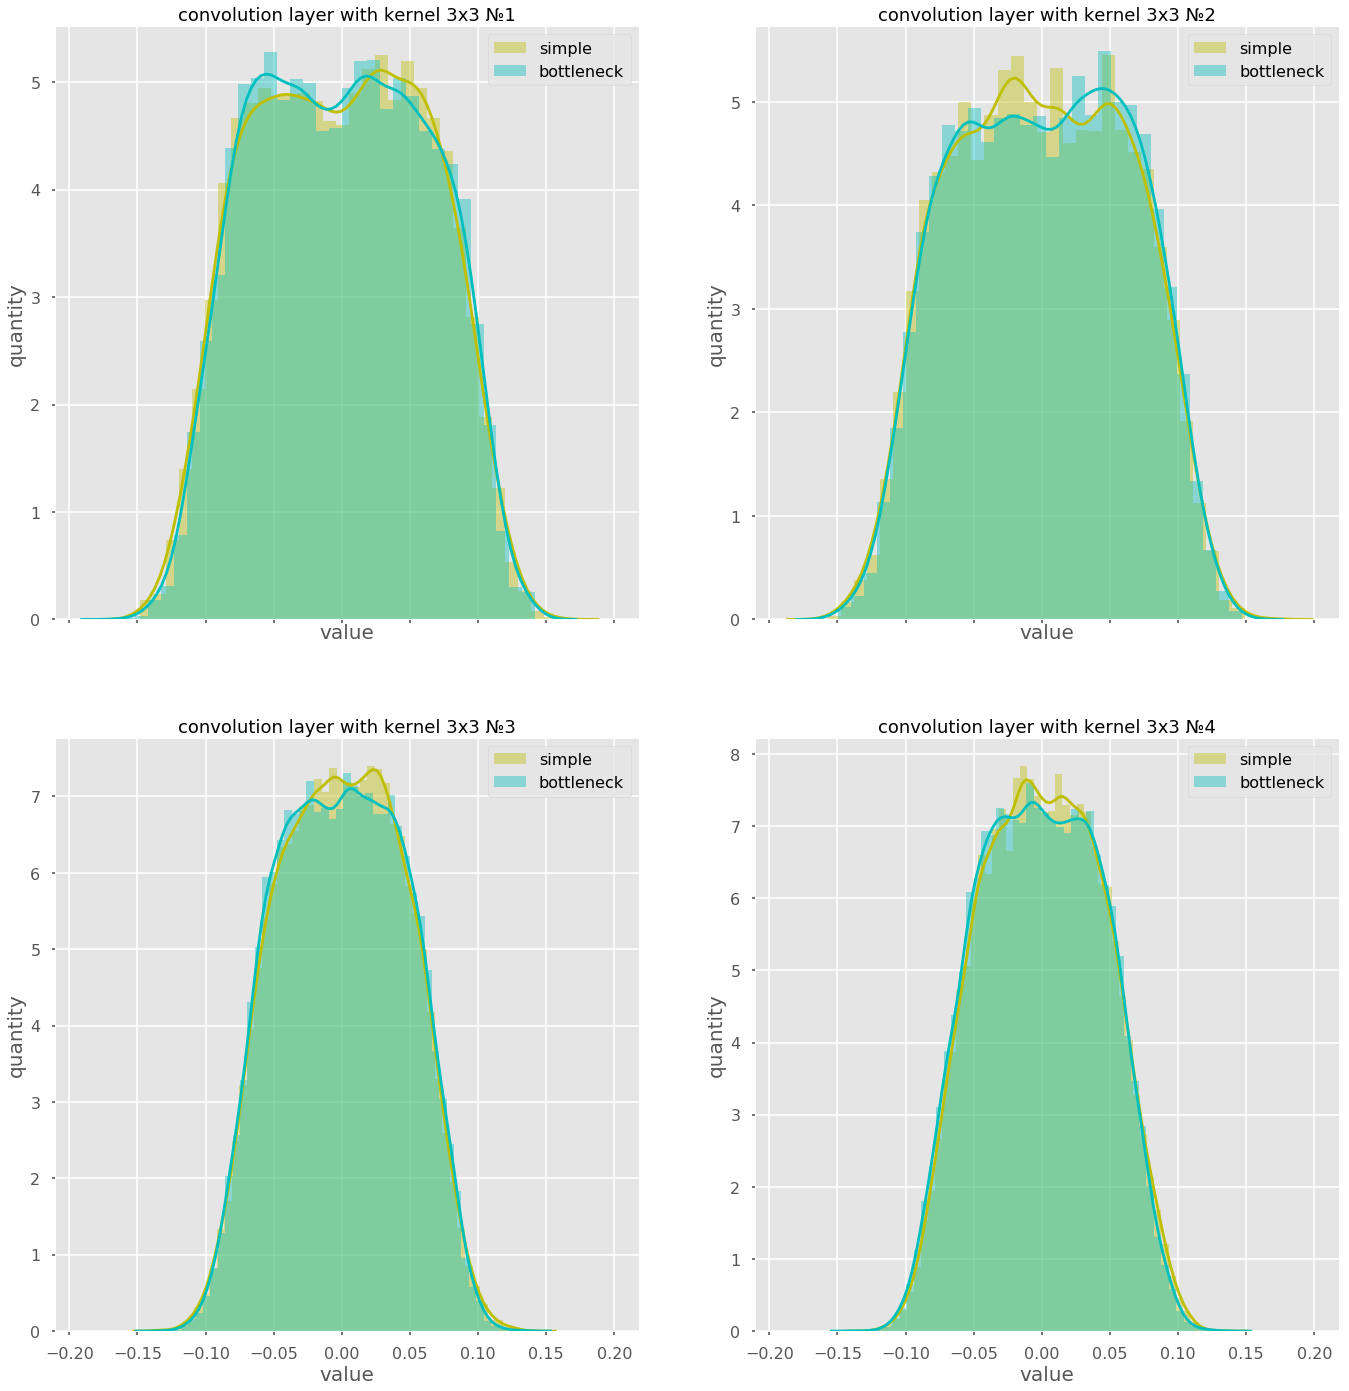

In [16]:
indices = [i for i in range(len(bottle_names)) if 'conv' in bottle_names[i][:8]]
_, ax = plt.subplots(2, 2, sharex='all', figsize=(23, 24))
ax = ax.reshape(-1)
num_plot = 0
for i,j in zip(np.where(res_names == 'layer-3')[0], np.where(bottle_names == 'layer-3')[0]):
    ax[num_plot].set_title('convolution layer with kernel 3x3 №{}'.format(num_plot + 1), fontsize=18)
    sns.distplot(res_weights[i].reshape(-1), ax=ax[num_plot], color='y', label='simple')
    sns.distplot(bottle_weights[j].reshape(-1), ax=ax[num_plot], color='c', label='bottleneck')
    ax[num_plot].legend()
    ax[num_plot].set_xlabel('value', fontsize=20)
    ax[num_plot].set_ylabel('quantity', fontsize=20)
    num_plot += 1
    

Graphs show, that distribution of ResNet with bottleneck block bigger than simple ResNet. It means that convolution 3x3 make smaller effect in train network, than convolutions 1x1. 

### And it's time to conclusions:
1. Convolutions with size 1x1 have have fewer parameters and allows train network faster, that with 3x3 convolutions, and 1x1 convolutions may have better quality.
2. Second layer after skipconnection in simple ResNet model have a bigger gradient than first layer and consequently will be train slowly.